<a href="https://colab.research.google.com/github/rajatvarma/IDL/blob/master/A2_GenerativeModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Deep Learning

<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 1, Part 3: Generative Models** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">


In this notebook we are going to cover two generative models for generating novel images:

1. Variational Autoencoders (**VAEs**)
2. Generative adversarial networks (**GANs**)


<img src="https://lilianweng.github.io/lil-log/assets/images/three-generative-models.png" width="500">


Your main goal will be to retrain these models on a dataset of your choice and do some experiments on the learned latent space.

You should first copy this notebook and enable GPU runtime in 'Runtime -> Change runtime type -> Hardware acceleration -> GPU **OR** TPU'.


In [ ]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import drive
# drive.mount('/content/drive', force_remount=True)


In [ ]:
!wget https://surfdrive.surf.nl/files/index.php/s/62Lnr1AtGe9b0v9/download -O face_dataset_64x64.npy

--2023-10-20 18:24:24--  https://surfdrive.surf.nl/files/index.php/s/62Lnr1AtGe9b0v9/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.100.27.67, 145.107.8.140, 2001:610:108:203b:0:a11:da7a:5afe, ...
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.100.27.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503083136 (480M) [application/octet-stream]
Saving to: ‘face_dataset_64x64.npy’

face_dataset_64x64. 100%[===================>] 479.78M  33.0MB/s    in 16s     

2023-10-20 18:24:41 (30.8 MB/s) - ‘face_dataset_64x64.npy’ saved [503083136/503083136]




### Dataset

This dataset is called [Flickr-Faces-HQ Dataset](https://github.com/NVlabs/ffhq-dataset). Here we will use a downsampled version of it (64x64x3) that will speed up all the experiments. [Download](https://surfdrive.surf.nl/files/index.php/s/LXBrnGGvUISlckW).

After downloading you should copy it to your google drive's main directory (or modify the code to load it from elsewhere).

After running the notebook on this default dataset you then need to find a dataset of your own.

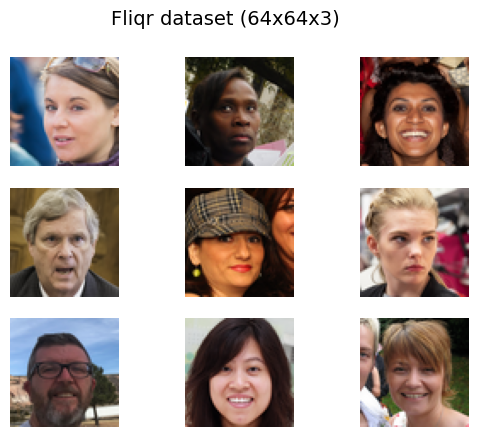

In [ ]:
def load_real_samples(scale=False):
    # We load 20,000 samples only to avoid memory issues, you can  change this value
    X = np.load('/content/face_dataset_64x64.npy',  fix_imports=True,encoding='latin1')[:20000, :, :, :]
    # Scale samples in range [-127, 127]
    if scale:
        X = (X - 127.5) * 2
    return X / 255.

# We will use this function to display the output of our models throughout this notebook
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()


dataset = load_real_samples()
grid_plot(dataset[np.random.randint(0, 1000, 9)], name='Fliqr dataset (64x64x3)', n=3)

## 2.1. Introduction

The generative models that we are going to cover both have the following components:

1. A downsampling architecture (encoder in case of VAE, and discriminator in case of GAN) to either extract features from the data or model its distribution.
2. An upsampling architecture (decoder for VAE, generator for GAN) that will use some kind of latent vector to generate new samples that resemble the data that it was trained on.

Since we are going to be dealing with images, we are going to use convolutional networks for upsampling and downsampling, similar to what you see below.

<img src="https://i2.wp.com/sefiks.com/wp-content/uploads/2018/03/convolutional-autoencoder.png" width="500">


#### Code for building these components:

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    input = tf.keras.Input(shape=in_shape)
    x = Conv2D(filters=filters, name='enc_input', **default_args)(input)

    for _ in range(n_downsampling_layers):
        x = Conv2D(**default_args, filters=filters)(x)

    x = Flatten()(x)
    x = Dense(out_shape, activation=out_activation, name='enc_output')(x)

    model = tf.keras.Model(inputs=input, outputs=x, name='Encoder')

    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers.
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images.
    """
    input = tf.keras.Input(shape=(latent_dim,))
    x = Dense(4 * 4 * 64, input_dim=latent_dim, name='dec_input')(input)
    x = Reshape((4, 4, 64))(x) # This matches the output size of the downsampling architecture

    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    for i in range(n_upsampling_layers):
        x = Conv2DTranspose(filters=filters, **default_args)(x)

    # This last convolutional layer converts back to 3 channel RGB image
    x = Conv2D(filters=3, kernel_size=(3,3), padding='same', activation=activation_out, name='dec_output')(x)

    model = tf.keras.Model(inputs=input, outputs=x, name='Decoder')
    model.summary()
    return model

### Convolutional Autoencoder example

Using these two basic building blocks we can now build a Convolutional Autoencoder (CAE).

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png" width="500">



Even though it's not a generative model, CAE is a great way to illustrate how these two components (convolutional and deconvolutional networks) can be used together to reconstruct images.

You can view such model as a compression/dimensionality reduction method as each image gets compressed to a vector of 256 numbers by the encoder and gets decompressed back into an image using the decoder network.

In [ ]:
def build_convolutional_autoencoder(data_shape, latent_dim, filters=128):
    encoder = build_conv_net(in_shape=data_shape, out_shape=latent_dim, filters=filters)
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)

    # We connect encoder and decoder into a single model
    autoencoder = tf.keras.Sequential([encoder, decoder])

    # Binary crossentropy loss - pairwise comparison between input and output pixels
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

    return autoencoder


# Defining the model dimensions and building it
image_size = dataset.shape[1:]
latent_dim = 512
num_filters = 128
cae = build_convolutional_autoencoder(image_size, latent_dim, num_filters)


## Training the Convolutional autoencoder to reconstruct images
for epoch in range(50):
    print('\nEpoch: ', epoch)

    # Note that (X=y) when training autoencoders!
    # In this case we only care about qualitative performance, we don't split into train/test sets
    cae.fit(x=dataset, y=dataset, epochs=1, batch_size=64)

    samples = dataset[:9]
    reconstructed = cae.predict(samples)
    grid_plot(samples, epoch, name='Original', n=3, save=False)
    grid_plot(reconstructed, epoch, name='Reconstructed', n=3, save=False)

*Note: You may experiment with the latent dimensionality and number of filters in your convolutional network to see how it affects the reconstruction quality. Remember that this also affects the size of the model and time it takes to train.*

---
---


## 2. 2. Variational Autoencoders (VAEs)

<img src="https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png" width="500">

#### Encoder network
This defines the approximate posterior distribution, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation. In this example, we simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. We output log-variance instead of the variance directly for numerical stability.

#### Decoder network
This defines the conditional distribution of the observation $z$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation. We model the latent distribution prior  as a unit Gaussian.

#### Reparameterization trick
To generate a sample  for the decoder during training, we can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $z$. However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, we use a reparameterization trick. In our example, we approximate  using the decoder parameters and another parameter  as follows:

$$z = \mu + \sigma\epsilon$$

where $\mu$ and $\sigma$  represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The  can be thought of as a random noise used to maintain stochasticity of $z$. We generate  from a standard normal distribution.

The latent variable  is now generated by a function of $\mu$ and $\sigma$ which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

#### Implementation

You can see how this trick is implemented below by creating a custom layer by sublassing tf.keras.layers.Layer.
It is then connected to the output of the original encoder architecture and an additional [KL](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) loss term is introduced.


In [ ]:
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

def build_vae(data_shape, latent_dim, filters=128):

    # Building the encoder - starts with a simple downsampling convolutional network
    encoder = build_conv_net(data_shape, latent_dim*2, filters=filters)

    # Adding special sampling layer that uses the reparametrization trick
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])

    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))

    # Define a custom layer for the KL loss calculation
    class KLLossLayer(tf.keras.layers.Layer):
        def call(self, inputs):
            z_mean, z_var = inputs
            kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
            # Add the KL loss to the model's losses
            self.add_loss(kl_loss / tf.cast(tf.keras.backend.prod(data_shape), tf.float32))
            return inputs  # Pass through the inputs unchanged

    # Apply the custom layer to z_mean and z_var
    _, _ = KLLossLayer()([z_mean, z_var])

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae

In [ ]:
# Training the VAE model

latent_dim = 64
encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim, filters=64)

# Generate random vectors that we will use to sample our latent space
for epoch in range(20):
    latent_vectors = np.random.randn(9, latent_dim)/6
    vae.fit(x=dataset, y=dataset, epochs=1, batch_size=8)

    images = decoder(latent_vectors)
    grid_plot(images, epoch, name='VAE generated images (randomly sampled from the latent space)', n=3, save=False)

*Note: again, you might experiment with the latent dimensionality, batch size and the architecture of your convolutional nets to see how it affects the generative capabilities of this model.*

---

## 2.3 Generative Adversarial Networks (GANs)

### GAN architecture
Generative adversarial networks consist of two models: a generative model and a discriminative model.

<img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-1-4842-3679-6_8/MediaObjects/463582_1_En_8_Fig1_HTML.jpg" width="500">

**The discriminator** model is a classifier that determines whether a given image looks like a real image from the dataset or like an artificially created image. This is basically a binary classifier that will take the form of a normal convolutional neural network (CNN).
As an input this network will get samples both from the dataset that it is trained on and on the samples generated by the **generator**.

The **generator** model takes random input values (noise) and transforms them into images through a deconvolutional neural network.

Over the course of many training iterations, the weights and biases in the discriminator and the generator are trained through backpropagation. The discriminator learns to tell "real" images of handwritten digits apart from "fake" images created by the generator. At the same time, the generator uses feedback from the discriminator to learn how to produce convincing images that the discriminator can't distinguish from real images.




In [ ]:
from tensorflow.keras.optimizers import Adam

def build_gan(data_shape, latent_dim, filters=128, lr=0.0002, beta_1=0.5):
    optimizer = Adam(learning_rate=lr, beta_1=beta_1)

    # Usually thew GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out='tanh', filters=filters)

    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1, filters=filters) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator, generator, GAN


### Definining custom functions for training your GANs

---




In [ ]:
def run_generator(generator, n_samples=100):
    """
    Run the generator model and generate n samples of synthetic images using random latent vectors
    """
    generator_input = np.random.randn(n_samples, latent_dim)

    return generator.predict(generator_input)


def get_batch(generator, dataset, batch_size=64):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    batch_size //= 2 # Split evenly among fake and real samples

    fake_data = run_generator(generator, n_samples=batch_size)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)

    return X, y


def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, batch_size=64):

    batches_per_epoch = int(dataset.shape[0] / batch_size / 2)
    for epoch in range(n_epochs):
        for batch in tqdm(range(batches_per_epoch)):

            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, dataset, batch_size=batch_size)
            discriminator_loss = discriminator.train_on_batch(X, y)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size, latent_dim)
            y_gan = np.ones([batch_size, 1])
            generator_loss = gan.train_on_batch(X_gan, y_gan)

        noise = np.random.randn(16, latent_dim)
        images = generator.predict(noise)
        grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)


In [ ]:
## Build and train the model (need around 10 epochs to start seeing some results)

latent_dim = 256
discriminator, generator, gan = build_gan(dataset.shape[1:], latent_dim, filters=128)
dataset_scaled = load_real_samples(scale=True)

train_gan(generator, discriminator, gan, dataset_scaled, latent_dim, n_epochs=20)

*Note: the samples generated by small GANs are more diverse, when compared to VAEs, however some samples might look strange and do not resemble the data the model was trained on.

In [ ]:
# Your code